# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


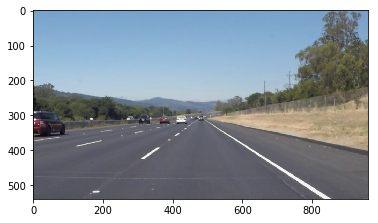

In [2]:
#reading in an image
orig_image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting 0575
print('This image is:', type(orig_image), 'with dimensions:', orig_image.shape)
plt.imshow((orig_image))  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def colormask(img,c_mask_low,c_mask_high):
    """
    Apply a hsv colormask on image and then return it
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Threshold the HSV image to get only yellow/white   
    c_mask = cv2.inRange(img_hsv, c_mask_low, c_mask_high)

    img_c_masked = cv2.bitwise_and(img, img, mask=c_mask)
    
    return img_c_masked
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def increase_contrast(img,clipLimit,tileGridSize):
    """Applies small increase in contrast via CLAHE
    from https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
    """
    # Converting image to LAB Color model
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Splitting the LAB image to different channels 
    l, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    tileGridSize = (tileGridSize,tileGridSize)
    clahe = cv2.createCLAHE(clipLimit, tileGridSize)
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to RGB model
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def movingAverage(avg_array, new_sample):
    """takes in an array of values(ignoring zeros in it), a new value and computes the average"""
    idx = avg_array != 0
    avg_new = (sum(avg_array[idx]) + new_sample) / (sum(idx)+1)
    return avg_new;

def make_two_lines(img,lines,ysize_f,old_slope_y0,min_max_slope,mAP):
    """
    this function takes in the lines from hough transform and averages and interpolates them
    ouput are lines which contains an averaged line for right side and one for left side.
    
    INPUT:
    img = image(getting the size of it)
    ysize_f = range of sight factor in front, also used in region of interest
    old_slope_y0 =  slope and y0 of the right and left line of the frame before
    max_slope = value which determines to ignore some lines, if their slope is to high or low
    mAP = moving Average Period, this number of frames will be averaged
    
    OUTPUT:
    new_lines = one line for right and one line for left,
                this is formatted to make different colorization of lines possible  
    old_slope_y0 = in this frame used slope and y0
    lines_found = two value vector which gives information about wether a line was detected or not

    """
    xsize = img.shape[1]
    ysize = img.shape[0]
    
    # Initializing
    slope_r =0
    slope_l =0
    slope_r_line = []
    slope_l_line = []
    y0_r = 0
    y0_l = 0
    y0_r_line = []
    y0_l_line = []
    l_length_r = []
    l_length_l = []
    lines_found = [0,0];
    
    # Do this part only if lines are found
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                # getting slope, y0 and length of every line
                slope = (y2-y1)/(x2-x1)
                y0 = y1 - slope*x1
                l_length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                # classify in right or left lane according to slope
                # and put values for slope, y0 and length in list
                if slope >min_max_slope[0] and slope <min_max_slope[1]:
                    slope_r_line.append(slope)
                    y0_r_line.append(y0)
                    l_length_r.append(l_length)
                    lines_found[0] = 1
                elif slope <(-min_max_slope[0]) and slope >(-min_max_slope[1]):        
                    slope_l_line.append(slope)
                    y0_l_line.append(y0)
                    l_length_l.append(l_length)
                    lines_found[1] = 1
            
        # total length of right and left lines
        l_length_r_total = np.sum(l_length_r)
        l_length_l_total = np.sum(l_length_l)
        
        # Calculating slope and y0 with weighting in the length, 
        # to make longer lines more dominant
        for index,line in enumerate(l_length_r):
            slope_r = slope_r + l_length_r[index]/l_length_r_total * slope_r_line[index]
            y0_r = y0_r + l_length_r[index]/l_length_r_total * y0_r_line[index]
            
        for index,line in enumerate(l_length_l):
            slope_l = slope_l + l_length_l[index]/l_length_l_total * slope_l_line[index] 
            y0_l = y0_l + l_length_l[index]/l_length_l_total * y0_l_line[index] 
            
        # Calculating the moving average
        if len(old_slope_y0):
            slope_r = movingAverage(old_slope_y0[0], slope_r)
            y0_r = movingAverage(old_slope_y0[1], y0_r)
            
        if len(old_slope_y0):
            slope_l = movingAverage(old_slope_y0[2], slope_l)
            y0_l = movingAverage(old_slope_y0[3], y0_l)
            
    ######## Do this part if no lines are found
    # if no lines are found in this frame, get slope and y0 of old frame
    if not lines_found[0]:
        slope_r =  old_slope_y0[0][-1]         
        y0_r =  old_slope_y0[1][-1]
    if not lines_found[1]:
        slope_l =  old_slope_y0[2][-1]
        y0_l =  old_slope_y0[3][-1]  
    #######    
    
    # Calculating the four values for the two points, which define the final line 
    x0_r = (ysize-y0_r)/slope_r
    x0_l = (ysize-y0_l)/slope_l
    
    y1_r = ysize/ysize_f
    y1_l = ysize/ysize_f
    
    x1_r = (y1_r-y0_r)/slope_r
    x1_l = (y1_l-y0_l)/slope_l
    
    # Putting the points into 'new_lines', which is formatted shape=(2,1,1,4) 
    # to make different colorization of lines possible 
    new_lines = np.zeros(shape=(2,1,1,4), dtype=np.int32)
    
    new_lines[0][0]= [x0_r,ysize,x1_r,y1_r]
    new_lines[1][0]= [x0_l,ysize,x1_l,y1_l]
    
    # return slope and y0, which are used in this frame
    slope_y0 = [slope_r,y0_r,slope_l,y0_l]
    
    #  put in 'old_slope_y0' to make it available for next frame
    if not len(old_slope_y0):
        old_slope_y0 = np.zeros(shape=(4,mAP))
    else:
        for idx in range(4):            
            old_slope_y0[idx] = np.roll(old_slope_y0[idx],-1)
            old_slope_y0[idx][-1]= slope_y0[idx]
    
    return (new_lines,old_slope_y0,lines_found)
    

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

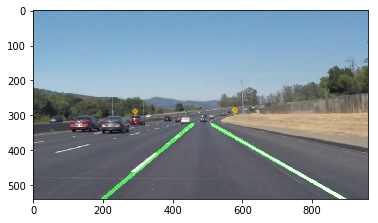

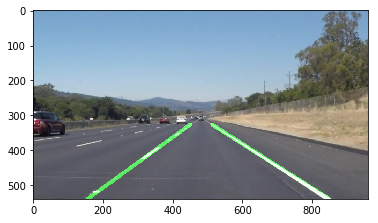

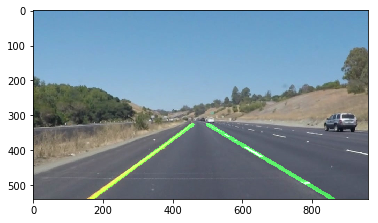

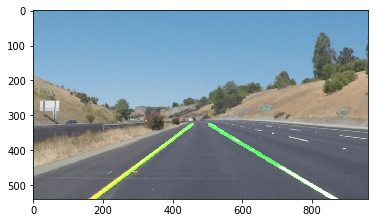

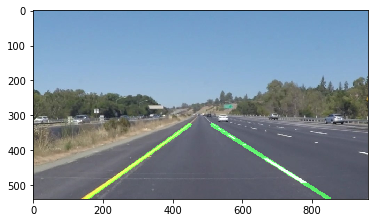

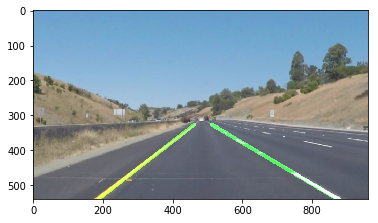

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images# Read in and grayscale the image
images = 1;
save  = 1;

def process_image(img):
    global old_slope_y0  
    # blur a bit first, especially good for challenge video, the shadow part
    frame = gaussian_blur(img, 9)
    # slight increase contrast via CLAHE
    frame = increase_contrast(frame,0.7,10)

    # Color mask yellow and white
    # define range of color in HSV
    lower_yel = np.array([19,40,100])
    upper_yel = np.array([31,255,255])
    img_c_yel = colormask(frame,lower_yel,upper_yel)

    lower_wht = np.array([0,0,180])
    upper_wht = np.array([255,30,255])
    img_c_wht = colormask(frame,lower_wht,upper_wht) 

    frame_c = weighted_img(img_c_wht, img_c_yel,1,1)
    frame = weighted_img(frame_c, frame,1,1)

    # grayscaling
    frame = grayscale(frame)

    # Gaussian smoothing, Blurring
    frame = gaussian_blur(frame, 5)
    
    # Canny edge detection
    frame = canny(frame, 45, 140)

    # Defining a four sided polygon to mask   
    xsize = img.shape[1]
    ysize = img.shape[0]

    # Range of Sight  
    # ysize_factor is very important(see 'make_two_lines')
    # xsize_factor_top ≈ 0
    # xsize_factor_bottom ≈ 0
    xsize_f_top = 0.10
    xsize_f_bottom = 0.03
    ysize_f = 1.65

    # top left, top right, bottom left, bottom right
    vertices = np.array([[(xsize/2*(1+xsize_f_top), ysize/ysize_f),
                          (xsize/2*(1-xsize_f_top), ysize/ysize_f),
                          (xsize*(xsize_f_bottom), ysize), 
                          (xsize*(1-xsize_f_bottom), ysize)]], 
                        dtype=np.int32)
    # mask region
    frame = region_of_interest(frame, vertices)    

    # Define the Hough transform parameters
    rho = 3 # distance resolution in pixels of the Hough grid
    theta = np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 60    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 100 #minimum number of pixels making up a line
    max_line_gap = 250   # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(frame, rho, theta, threshold, np.array([]),min_line_len, max_line_gap)

    # the line below makes sure that there will be a line even if no line is detected
    # if lines are detected,lines_found = 1, so the lines will be green
    # if no lines are detected, lines_found = 0, it takes the line from the frame before and draws it in red        
    max_slope = [0.3, 1.4]
    mAP = 4 # moving average period
    # Run function which computes only 2 lines(1 left,1 right) 
    # from hough lines and inter/extrapolates from ysize/ysize_f to ysize
    [new_lines, old_slope_y0,lines_found] = make_two_lines(img,lines,ysize_f,old_slope_y0,max_slope,mAP)

    img_black_w_lines = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    color_l = 255,0,0
    color_r = 255,0,0

    if lines_found[0]: 
        color_r = 0,240,0
    if lines_found[1]:
        color_l = 0,240,0   

    draw_lines(img_black_w_lines, new_lines[0],color_r,10)
    draw_lines(img_black_w_lines, new_lines[1],color_l,10)

    # Combine original and image with lines
    result = weighted_img(img_black_w_lines, img, 1, 0.6)
    #frame = cv2.cvtColor(frame,cv2.COLOR_GRAY2RGB)  
    #result = weighted_img(frame, result, 1, 0.6)

    return result

if images: 
    for img_name in os.listdir("test_images/"):
        # read image
        img = mpimg.imread('test_images/' + img_name)
        # reset slope and y0 before each image
        old_slope_y0 =[]        
        
        # process image
        result = process_image(img)
        
        # Plot results
        fig = plt.figure()
        plt.imshow(result)

    if save :
        plt.savefig('test_images_output/' + img_name)
    # then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

# the line below (old_slope_y0 =[]) makes sure that there will be a line even if no line is detected
# if lines are detected,lines_found = 1, so the lines will be green
# if no lines are detected, lines_found = 0, it takes the line from the frame before and draws it in red  

old_slope_y0 =[]
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:12<00:00, 17.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 13.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">+
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
old_slope_y0 =[]
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:39<00:00, 19.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 40.7 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
old_slope_y0 =[]
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:27<00:00,  8.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 28.7 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))